# Generate images for writeup

In [84]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
from laneline import *
import cv2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/chris/anaconda2/envs/py3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['figsize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


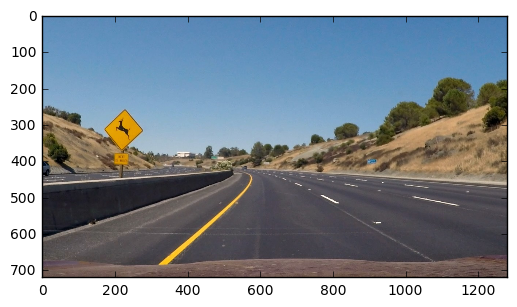

In [86]:
#load
img = cv2.imread('../test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imshow(img)


In [87]:
lanefitter = LaneLineFinder('camera.json')

In [88]:
'''calculates the warp matrices'''
points = np.array([[210,lanefitter.IMAGE_Y],[595,450],[685,450],[1100,lanefitter.IMAGE_Y]], np.float32)
dst = np.array([[210,lanefitter.IMAGE_Y],[210,0],[1100,0],[1100,lanefitter.IMAGE_Y]], np.float32)

M = cv2.getPerspectiveTransform(points, dst)
M_inv = cv2.getPerspectiveTransform(dst,points)


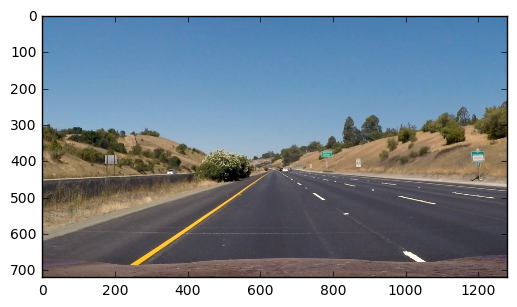

In [89]:
#load
img2 = cv2.imread('../test_images/straight_lines1.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
imshow(img2)

img2 = cv2.undistort(img2, lanefitter.mtx, lanefitter.dist, None, lanefitter.mtx)

warped2 = cv2.warpPerspective(img2, M, (lanefitter.IMAGE_X,lanefitter.IMAGE_Y))

(0, 1280)

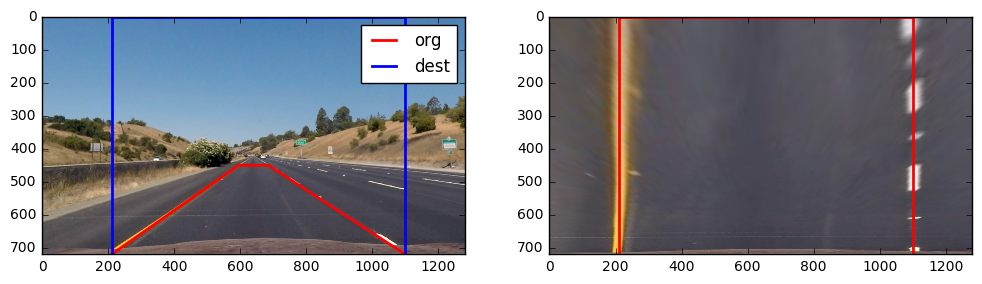

In [90]:
figure(figsize=(12,6))
subplot(1,2,1)
imshow(img2)
plot([p[0] for p in points],[p[1] for p in points],'red',linewidth=2, label='org')
plot([p[0] for p in dst],[p[1] for p in dst],'blue',linewidth=2,label='dest')
legend()
ylim(720,0)
xlim(0,1280)

subplot(1,2,2)
imshow(warped2)
plot([p[0] for p in dst],[p[1] for p in dst],'red',linewidth=2)
ylim(720,0)
xlim(0,1280)


In [91]:
import pandas as pd

In [92]:
from IPython.display import HTML

In [104]:
df.to_html(index=False)

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>x_dest</th>\n      <th>x_org</th>\n      <th>y_dest</th>\n      <th>y_org</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <td>210.0</td>\n      <td>210.0</td>\n      <td>720.0</td>\n      <td>720.0</td>\n    </tr>\n    <tr>\n      <td>210.0</td>\n      <td>595.0</td>\n      <td>0.0</td>\n      <td>450.0</td>\n    </tr>\n    <tr>\n      <td>1100.0</td>\n      <td>685.0</td>\n      <td>0.0</td>\n      <td>450.0</td>\n    </tr>\n    <tr>\n      <td>1100.0</td>\n      <td>1100.0</td>\n      <td>720.0</td>\n      <td>720.0</td>\n    </tr>\n  </tbody>\n</table>'

In [93]:
df = pd.DataFrame({'x_org':[p[0] for p in points]
,'y_org':[p[1] for p in points]
,'x_dest':[p[0] for p in dst]
,'y_dest':[p[1] for p in dst]})

HTML(df.to_html(index=False))

x_dest,x_org,y_dest,y_org
210.0,210.0,720.0,720.0
210.0,595.0,0.0,450.0
1100.0,685.0,0.0,450.0
1100.0,1100.0,720.0,720.0


In [94]:
#undistort
undist = cv2.undistort(img, lanefitter.mtx, lanefitter.dist, None, lanefitter.mtx)
#warp
warped = cv2.warpPerspective(undist, lanefitter.M, (lanefitter.IMAGE_X,lanefitter.IMAGE_Y))
#generate a lane line mask
mask = lane_line_mask(warped)

#left/right split
L = mask[:,:int(mask.shape[1]/2)]
R = mask[:,int(mask.shape[1]/2):]

#flip the y values for sanity
left = L[::-1,:]
right = R[::-1,:]

#remove noise
P_left = simple_bayes_filter(left,lanefitter.p_move,prior=lanefitter.prior_left)
P_right = simple_bayes_filter(right,lanefitter.p_move,prior=lanefitter.prior_right)

left2= filter_image_by_bayes(left,P_left)
right2 = filter_image_by_bayes(right,P_right)

p0 = [0,0,220*lanefitter.xm_per_pix,885*lanefitter.xm_per_pix] #intial fit params

r =fit(left2,right2,xm_per_pix=lanefitter.xm_per_pix, ym_per_pix=lanefitter.ym_per_pix,p0=p0)

y=np.arange(lanefitter.IMAGE_Y)
left_fit, right_fit = lanefitter.lane_line_model(r,y*lanefitter.ym_per_pix)

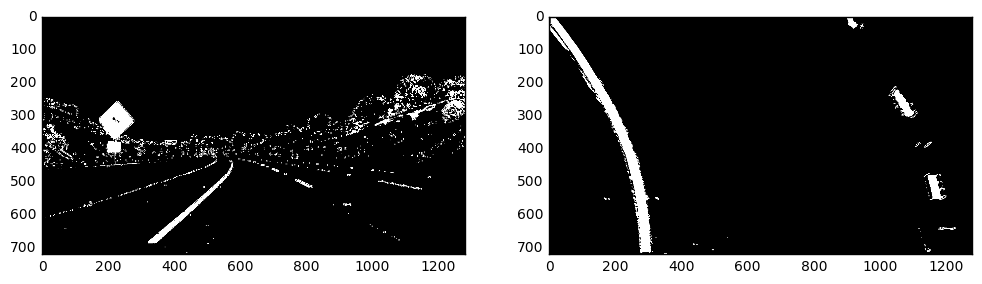

In [95]:
figure(figsize=(12,6))
subplot(1,2,1)
imshow(lane_line_mask(img),cmap='gray')
subplot(1,2,2)
imshow(mask,cmap='gray')

(0, 640)

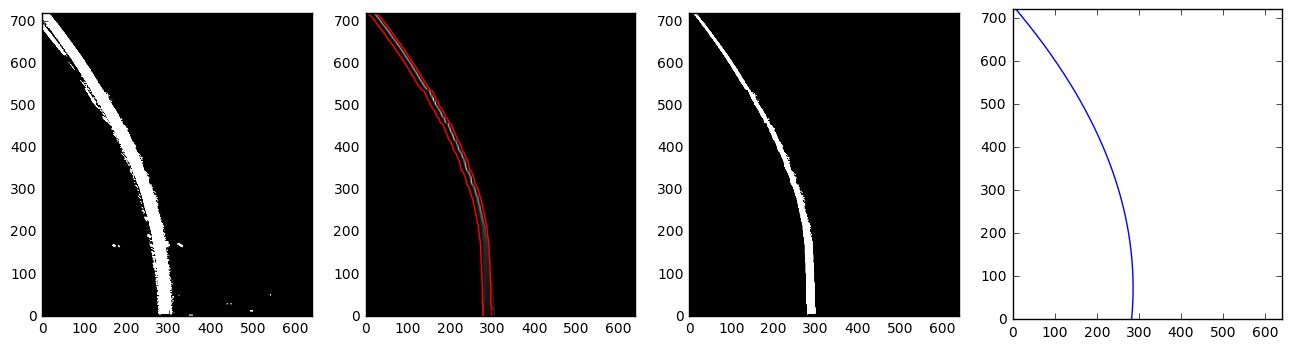

In [96]:
nx1,nx2,y=[],[],[]

for i in range(P_left.shape[0]):
    d = np.cumsum(P_left[i,:])
    a = np.argmax(d[d <= .25])
    b = np.argmax(d[d <= .75])
    c = np.argmax(d[d <=.5])

    a = c-max(c-a,10)
    b = c+max(b-c,10)

    nx1.append(a)
    nx2.append(b)
    y.append(i)


figure(figsize=(16,4))
subplot(1,4,1)
imshow(left,cmap='gray')
ylim(0,720)

subplot(1,4,2)
imshow(P_left,cmap='gray')
plot(nx1,y,color='red')
plot(nx2,y,color='red')
ylim(0,720)
xlim(0,640)


subplot(1,4,3)
imshow(left2,cmap='gray')
ylim(0,720)


subplot(1,4,4)
plot(left_fit,y)
ylim(0,720)
xlim(0,640)

(0, 1280)

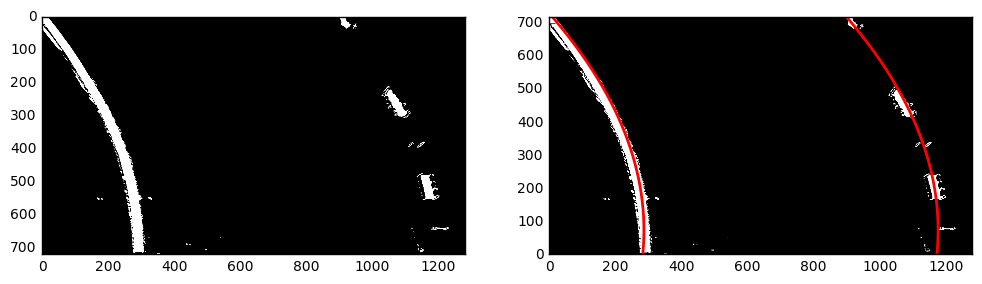

In [97]:
figure(figsize=(12,6))
subplot(1,2,1)
imshow(mask,cmap='gray')

subplot(1,2,2)
imshow(mask[::-1,:],cmap='gray')
plot(left_fit,y,'red',linewidth=2)
plot(right_fit,y,'red',linewidth=2)
ylim(0,720)
xlim(0,1280)

In [98]:
r

array([ -2.02384520e-03,   1.23743809e-02,   1.49322145e+00,
         4.70817466e+00])

In [99]:
minimap, newwarp = lanefitter.draw_lines(r)

In [100]:
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
result = cv2.addWeighted(result, 1, minimap, 0.5, 0)

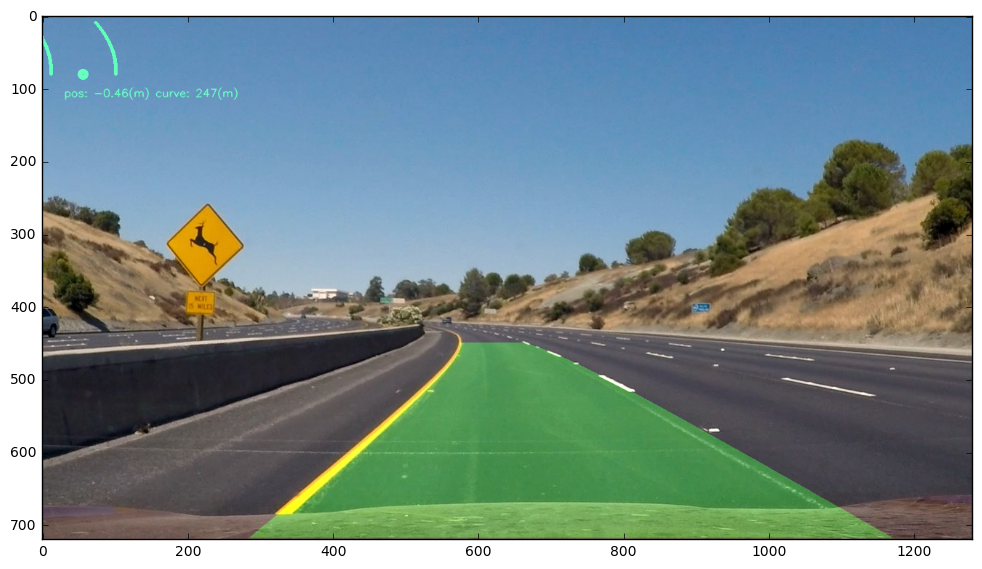

In [101]:
figure(figsize=(12,12))
imshow(result)

In [106]:
print('''
<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>x_dest</th>\n      <th>x_org</th>\n      <th>y_dest</th>\n      <th>y_org</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <td>210.0</td>\n      <td>210.0</td>\n      <td>720.0</td>\n      <td>720.0</td>\n    </tr>\n    <tr>\n      <td>210.0</td>\n      <td>595.0</td>\n      <td>0.0</td>\n      <td>450.0</td>\n    </tr>\n    <tr>\n      <td>1100.0</td>\n      <td>685.0</td>\n      <td>0.0</td>\n      <td>450.0</td>\n    </tr>\n    <tr>\n      <td>1100.0</td>\n      <td>1100.0</td>\n      <td>720.0</td>\n      <td>720.0</td>\n    </tr>\n  </tbody>\n</table>
''')


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>x_dest</th>
      <th>x_org</th>
      <th>y_dest</th>
      <th>y_org</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>210.0</td>
      <td>210.0</td>
      <td>720.0</td>
      <td>720.0</td>
    </tr>
    <tr>
      <td>210.0</td>
      <td>595.0</td>
      <td>0.0</td>
      <td>450.0</td>
    </tr>
    <tr>
      <td>1100.0</td>
      <td>685.0</td>
      <td>0.0</td>
      <td>450.0</td>
    </tr>
    <tr>
      <td>1100.0</td>
      <td>1100.0</td>
      <td>720.0</td>
      <td>720.0</td>
    </tr>
  </tbody>
</table>



## Advanced Lane Line Finder

### 1. Camera Calibration

The camera was calibrates by finding chessboard corners using `cv2.findChessboardCorners` and mapping those corners onto a calculated grid.
Those points were then fed to `cv2.calibrateCamera` to calculate the camera coefficients which were then saved to a file camera.json. The code for this is found in calibrate.ipynb

To undistort an image, the camera json file is loaded and used with `cv2.undistort`. A sample output from calibration is below:

![alt text](./results/calibration.png "undistored") 



### 3. Perspective Transform

I manually observed the x,y pixel coordinates of the lanes in straight lane image and calculated a perspective transform to map those points to a rectangle. Doing so transforms that section of road to one that appears as if being viewed from above. I calculate only the transformation matrix and inverse tranformation and store them in the LaneLineFinder class.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>x_dest</th>
      <th>x_org</th>
      <th>y_dest</th>
      <th>y_org</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>210.0</td>
      <td>210.0</td>
      <td>720.0</td>
      <td>720.0</td>
    </tr>
    <tr>
      <td>210.0</td>
      <td>595.0</td>
      <td>0.0</td>
      <td>450.0</td>
    </tr>
    <tr>
      <td>1100.0</td>
      <td>685.0</td>
      <td>0.0</td>
      <td>450.0</td>
    </tr>
    <tr>
      <td>1100.0</td>
      <td>1100.0</td>
      <td>720.0</td>
      <td>720.0</td>
    </tr>
  </tbody>
</table>


The org points are mapped to be transformed into the dest points
![alt text](./results/straight1_warp.png "warp")


```python
def calc_warp_matrix(self):
    '''calculates the warp matrices'''
    points = np.array([[210,self.IMAGE_Y],[595,450],[685,450],[1100,self.IMAGE_Y]], np.float32)
    dst = np.array([[210,self.IMAGE_Y],[210,0],[1100,0],[1100,self.IMAGE_Y]], np.float32)

    M = cv2.getPerspectiveTransform(points, dst)
    M_inv = cv2.getPerspectiveTransform(dst,points)

    return M, M_inv
```

### 3. Lane line masking

To identify lane lines a combination of color thresholds and directional gradients were used. Building on the method used in the first lane line project, white and yellow lines were identified indiviually by a color threshold.

```python
#yellow mask
lowery = np.array([175,175,0])
upper= np.array([255,255,150])
yellow = cv2.inRange(img, lowery, upper)

#white mask
lowery = np.array([195,195,195])
upper= np.array([255,255,255])
white = cv2.inRange(img, lowery, upper)
```

Additionally, by converting to an HLS colorspace, it was observed that yellow lines were mostly found at high S and low H values while white lines were found at high H values. So masks for those channels were created and ORed with the project 1 lines.

```python
a=apply_mask(S,(120,255))
b=apply_mask(L,(210,255))
c=apply_mask(H,(0,50))

#mix in the first project's findings
yellow_line = np.logical_and( np.logical_or(a,yellow), c)
white_line = np.logical_or(b ,white)

return np.logical_or(yellow_line, white_line)
```
Color alone was not reliable enough to always find the lanes, so a mix of x gradients and gradient angle thresholds were used also. The final code is in the lane_line_mask function.

![alt text](./results/test2_masking.png "masking")


### 4 Curve Fitting

The goal here was to fit the lane lines to a quadratic function of y. To do this a few steps were needed.

![alt text](./results/test2_left_process.png "line fit1")

##### 1. Split the warped and masked image into left and right images
This was fairly simple and naive, left lanes live on the left half side of the image and right live on the right half.

##### 2. Filter out unwanted points left over from overly aggresive thresholding
To cleanup the images I used simple bayseian filter that walked upwards from the bottom and constructed a per row probability distribution of where the lane lines might be.
This distribution was then used to filter out points from the source image by considering only points falling within the interquartile range and/or a fixed width window around the per row mean.

```python
def simple_bayes_filter(img,p_move,prior=None):
    '''walk vertically through a lane line image and generate a per row 
        probability distribution of where the lane line is'''
    
    ys,xs = img.shape[:2]
        
    if prior is None:
        prior = safe_norm(prior,xs)
        
    #1. sample a distribution for a set of rows,
    #2. multiply it by our prior belief of where the lane line is (the prior set of rows)
    #3. Add some uncertainty as we move vertically by convolving against p_move
    
    row_probs=[]
    for i in range(ys):

        #get our current observation distribution
        p = observation_dist(img,i,10,10)
        
        #mix with prior
        p = safe_norm(p*prior,xs)
        row_probs.append(p)
        
        #move left or right a little bit
        prior = safe_norm(np.convolve(p,p_move, mode='same'),xs)
                
    return np.array(row_probs)
```

##### 3. Calculate an appropriate loss function and pass the data to an optimizer
The model for the lines is quadratic ie Ay*2+B*y+C, and because the lines should be parallel at all y values they should have the same parameters and differ only by a translation. A fourth Paramter D was used to set the lane width and a loss function was defined as the MSE of each line summed together. This was passed to `scipy.optimize.minimize` using the L-BFGS-B solver to include optional bounds on the lane width etc.

```python
def f(p):
    '''error function for fit: total MSE for both lines'''
    A,B,C,D = p
    #D=850 #fix lane width?
    pred_x_l = A*(yl**2)+B*yl+C
    pred_x_r = A*(yr**2)+B*yr+(C+D)
    return np.mean((xl-pred_x_l)**2)+ np.mean((xr-pred_x_r)**2)
```


![alt text](./results/test2_fit_result.png "line fit2")



### 5. Curvature and position

Lane line curvature and vehicle position from center was calculated with the formulas below. `r` is the fit parameter vector with `r[2]` being the x position of the left lane line and `r[3]` being the width of the lane.

```python
def lane_line_curve(self,r,y_eval=0):
    '''calculates road curvature'''
    return ((1 + (2*r[0]*y_eval + r[1])**2)**1.5) / np.absolute(2*r[0])

def lane_line_position(self,r):
    '''calculates vehicle position relative to lane center'''
    lane_center = (r[2]+r[3]*.5)
    position =  self.IMAGE_X*self.xm_per_pix*.5 -  lane_center
    return position
```

### 6. Drawing!

To draw the lane lines back on the road the inverse perspective transform `M_inv` was used. I also plotted a minimap for fun in the top left. The code is in the draw_lines function.


![alt text](./results/test2_final_frame_result.png "final")



### Pipeline (video)

Here's a [link to my video result](./project_video_result.mp4)


<video width="960" height="540" controls>
  <source src="project_video_result.mp4">a
</video> 

---

### Discussion

The pipeline suffers from some major problems. While it attempts to track the lane lines position it currently does not do a good job of preventing wild swings in curvature etc. Additionally it is very slow. As coded producing the project_video takes about 6 minutes on a quadcore i7. Some simple heuristics might improve tolerance to false detections etc. The pipeline is also likely to fail on roads of differnet grade or S shaped curves where a higher order polynominal is needed. The reliance on color for detection is also unfortunetly critical. I doubt it would work at night or with a white or yellow car in the area of the perspective transform.
